<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import Nets 
from Nets import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Real Game Dynamics analysis  
The real game dynamcis shows huge difference performance in speed, stability of results, and also statistics of strategy 

## Learning history 

In [6]:
# network39, with iterations 200,  epochs 5 
for iters1, noise in enumerate(3 * [0.0]):
    rewards = []
    for iters2 in np.arange(30):
        perform = 0
        for k in range(10):
            weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_{}_{}'.format(iters1, iters2)
            pregame = PretrainTest(weight_write = weight, holes = 50, inputs_type = (1, 0))
            pregame.game.net.load_state_dict(torch.load(weight))
            pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0)
            perform += (pregame.Performance[0])
        rewards.append(perform/10)
    print (iters1, rewards)
    np.save('Rewards_{}_{}.npy'.format(iters1, 39), rewards)


0 [-0.09198766934171601, 0.1256958998246444, 0.15505620564762787, 0.23520767846911328, 0.3510247681972392, 0.4069556298331582, 0.3936761393276935, 0.44143628061257134, 0.44677875228651764, 0.51247990899198, 0.4884411594503666, 0.5505865877590745, 0.4822093621913698, 0.5956151308997716, 0.5994941807884825, 0.6208593385284832, 0.6172044866442907, 0.6051465259018151, 0.6142323894846613, 0.6495627298521587, 0.5787789192430624, 0.599456947482144, 0.63199981535903, 0.6358620788367773, 0.6471141270681062, 0.6329944062777129, 0.5662187799213159, 0.6383919590512163, 0.6267681283425504, 0.5782939641713495]
1 [-0.017962075528303364, 0.09666566612990901, 0.13761353695373768, 0.19873629448992944, 0.31468188916204837, 0.25715404591161645, 0.359422520057807, 0.3950938131752094, 0.4267918292910142, 0.5134905059504867, 0.5405522706562568, 0.5061993022853308, 0.5967958427613468, 0.6031810260756804, 0.600018098779846, 0.5773041142191487, 0.5880893792229928, 0.6090365148602228, 0.6004539336866689, 0.58835

In [2]:
# Network0
for iters1, noise in enumerate(3 * [0.0]):
    rewards = []
    for iters2 in np.arange(30):
        perform = 0
        for k in range(10):
            weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_{}_{}'.format(iters1, iters2)
            pregame = PretrainTest(weight_write = weight, holes = 50, inputs_type = (1, 0))
            pregame.game.net.load_state_dict(torch.load(weight))
            pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0)
            perform += (pregame.Performance[0])
        rewards.append(perform/10)
    print (iters1, rewards)
    np.save('Rewards_{}_{}.npy'.format(iters1, 0), rewards)

0 [0.09698818286980347, 0.122333477229623, 0.15400658683237262, 0.24497824488268466, 0.22170817591470615, 0.2995842172146074, 0.3300380587445969, 0.23448165273526217, 0.2770769654483042, 0.3016424705183247, 0.2679732914190643, 0.22609152854112047, 0.28130294647088244, 0.3668856344613979, 0.2673901648028864, 0.36397806048722176, 0.24494778654616528, 0.35104896540997654, 0.24938904269479917, 0.37928575171784196, 0.28921590473332665, 0.3362153073170183, 0.2726573693194088, 0.2022360733717094, 0.27396710045313954, 0.2385483109515127, 0.217011829755607, 0.19184503542417225, 0.20692337274000905, 0.20575176416695498]
1 [-0.12309411194597678, 0.012189602286660293, 0.1169886313083665, 0.11663228602146662, 0.16196956229369955, 0.1899798772756997, 0.16457865358486506, 0.19903726949757283, 0.26740343934397987, 0.30497718606466495, 0.2968715737155935, 0.34762416985855715, 0.22593101613716554, 0.3452754461926834, 0.24849305305840735, 0.2661255914712902, 0.3635780359987167, 0.29449451590954406, 0.294

([<matplotlib.axis.YTick at 0x7fcf68a64908>,
 <a list of 5 Text yticklabel objects>)

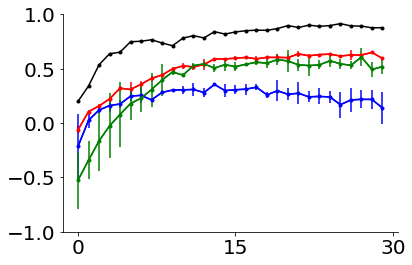

In [70]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
rewards = []
for iters, noise in enumerate(3 * [0.0]):
    rewards.append(np.load('Rewards_{}_{}.npy'.format(iters, 39)))
rewards = np.concatenate(rewards).reshape(3, 30)
rewards
plt.plot(np.mean(rewards, axis = 0), 'r.-')
plt.errorbar(np.arange(30), np.mean(rewards, axis = 0), yerr = np.std(rewards, axis = 0), color = 'r')
rewards = []
for iters, noise in enumerate(3 * [0.0]):
    rewards.append(np.load('Rewards_{}_{}.npy'.format(iters, 0)))
rewards = np.concatenate(rewards).reshape(3, 30)
plt.errorbar(np.arange(30), np.mean(rewards, axis = 0), yerr = np.std(rewards, axis = 0), color = 'b')
rewards
plt.plot(np.mean(rewards, axis = 0), 'b.-')
rewards = []
for iters, noise in enumerate(3 * [0.0]):
    rewards.append(np.load('Rewards_{}_{}_pre2.npy'.format(iters, 49)))
rewards = np.concatenate(rewards).reshape(3, 30)
rewards
plt.plot(np.mean(rewards, axis = 0), 'g.-')
plt.errorbar(np.arange(30), np.mean(rewards, axis = 0), yerr = np.std(rewards, axis = 0), color = 'g')
rewards = np.load('Rewards_0_0_pos.npy')
plt.plot(rewards, 'k.-')
plt.xticks([0, 15, 30], size = 20)
plt.yticks([-1, -0.5, 0, 0.5, 1], size = 20)

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

## Real game analysis 
**The behaviour is best analyzed by pwd and methods in different sizes of arena, in order to see the strategy is mediated by which loop, the big enviromental feedback(low freq related to size) or small action feedbakd(high freq)**

we take what shows good performance and send it for analysis 


In [41]:
# with strong action coupling?  
ratios = []
for holes in np.arange(0, 500, 10):
    performance0 = []
    ratio = np.zeros(1000)
    for i in range(1000):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_24'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
#         print (pregame.game.holes)
        pregame.game.seed = i
        pregame.game.reset(size = 15, train = False)
#         plt.matshow(pregame.game.grid.grid[2: 17, 2: 17])
#         plt.scatter(holes, np.sum(pregame.game.grid.grid[2: 17, 2: 17]))
        ratio[i] = np.sum(pregame.game.grid.grid[2: 17, 2: 17])
    ratios.append(ratio)

Ratio = []
Indexs = []
holes = np.arange(0, 500, 10)
for i, ratio in enumerate(ratios):
    print (holes[i], -int(np.mean(ratio) - 2)/34)
    Ratio.append(-int(np.mean(ratio) - 2)/34)
    print (np.where(ratio == int(np.mean(ratio)))[0][:10])
    Indexs.append(np.where(ratio == int(np.mean(ratio)))[0][:10])
np.save('Ratio_holes', Ratio)
np.save('Index_holes', Indexs)

In [57]:
# with strong action coupling?  
Performance0 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_24'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance0.append(performance0)

0.7024066678531515
0.6755472618548953
0.6731257229782284
0.6440554793890709
0.6161858163713212
0.6210964909130958
0.424048445254485
0.36609433603498587


In [58]:
# with strong action coupling?  
# with strong action coupling?  
Performance1 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_1_28'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance1.append(performance0)

0.6927540899098628
0.6723592695481391
0.67305905544576
0.6487360972902227
0.6172355443464841
0.5701485743724921
0.34861320172900917
0.2691797874217496


In [59]:
# with strong action coupling?  
# with strong action coupling?  
Performance2 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_2_28'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance2.append(performance0)

0.7025859373203462
0.6718549187466645
0.6784900738504386
0.6419489445742459
0.6160989564536608
0.5818052686945114
0.38984121331528954
0.33611398163434325


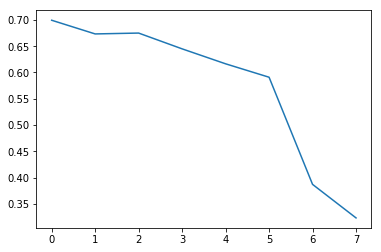

In [74]:
Performance = np.concatenate([Performance0, Performance1, Performance2]).reshape(3, 8, 10).transpose(1, 0, 2).reshape(8, 30)
np.save('performance_g_39', Performance)
plt.plot(np.mean(Performance, axis = 1))

In [76]:
# with strong action coupling?  
Performance0 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_2_19'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance0.append(performance0)

0.6093447905882896
0.6071382451496513
0.485317549485655
0.29122691824457525
0.1507319885891382
-0.034575538641912304
-0.36030527137921525
-0.4238471262580659


In [78]:
Performance1 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_1_16'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance1.append(performance0)

0.6034699116850148
0.5880763743728028
0.4221157619096451
0.24505783471091164
0.12125994644431744
-0.05905817254655752
-0.3172201439686374
-0.4084800037382754


In [80]:
Performance2 = []
for holes in [0, 10, 30, 50, 90, 130, 220, 400]:
    performance0 = []
    index = Indexs[holes//10]
    for i in range(10):
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_19'
        pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        ind = index[i]
        pregame.game.seed = ind
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, seed = ind)
        performance0.append(pregame.Performance)
    print (np.mean(performance0))
    Performance2.append(performance0)

0.6513096921524216
0.6511508374456211
0.4978879152332851
0.29200890271651425
0.11976754327017174
-0.05815716142986649
-0.3422096977791841
-0.44102987478821776


In [81]:
Performance = np.concatenate([Performance0, Performance1, Performance2]).reshape(3, 8, 10).transpose(1, 0, 2).reshape(8, 30)
np.save('performance_g_0', Performance)

([<matplotlib.axis.YTick at 0x7fcf6833da20>,
 <a list of 5 Text yticklabel objects>)

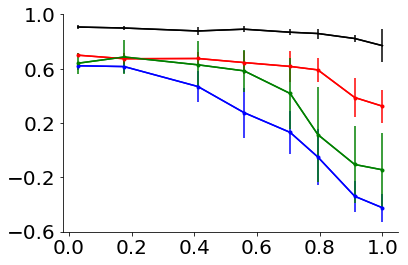

In [110]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
Performance_0 = np.load('performance_g_0.npy')
Performance_39 = np.load('performance_g_39.npy')
Performance_pos = np.load('Performance_pos_G.npy')
Performance_49 = np.load('performance_g_49.npy')
index = np.array([0, 1, 3, 5, 9, 13, 22, 40])
ratio = np.load('Ratio_holes.npy')[index]
plt.plot(ratio, np.mean(Performance_0, axis = 1), 'b.-')
plt.errorbar(ratio, np.mean(Performance_0, axis = 1), yerr = np.std(Performance_0, axis = 1), color = 'b')
plt.plot(ratio, np.mean(Performance_39, axis = 1), 'r.-')
plt.errorbar(ratio, np.mean(Performance_39, axis = 1), yerr = np.std(Performance_39, axis = 1), color = 'r')
plt.plot(ratio, np.mean(Performance_pos.reshape(8, 10), axis = 1), 'k')
plt.errorbar(ratio, np.mean(Performance_pos.reshape(8, 10), axis = 1), yerr = np.std(Performance_pos.reshape(8, 10), axis = 1), color = 'k')
plt.plot(ratio, np.mean(Performance_49, axis = 1), 'g.-')
plt.errorbar(ratio, np.mean(Performance_49, axis = 1), yerr = np.std(Performance_49, axis = 1), color = 'g')
plt.xticks(size = 20)
plt.yticks([-0.6, -0.2, 0.2, 0.6, 1], size = 20)

## test dynamics vs decoding effects 

Performance17 = []
for holes in [0, 10, 20, 30, 50]:
    weight = 'weights_fix3/weights4/rnn_1515tanh512_checkpoint17_1_29'
    pregame = PretrainTest(weight_write = weight, holes = holes, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
    pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0)
    print (pregame.Performance)
    Performance17.append(pregame.Performance)

In [ ]:
## Real game analysis 
Performance0 = []
for i in range(3):
    performance0 = []
    for size in [15, 20 ,30]:
        weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_{}_19'.format(i)
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        pregame.TestAllSizes(size_range = [size], limit_set = 8, test_size = 0)
        print (pregame.Performance)
        performance0.append(pregame.Performance)
    Performance0.append(performance0)

[0.8960066124462813]
[0.36677845283547733]


1.0 -1


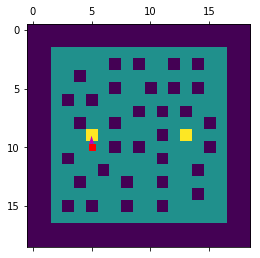

In [19]:
size = 15
PC_traces = []
torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
#     start = (15, 15)
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_0'
    game = ValueMaxGame(grid_size = (size, size), holes = 400, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
   
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        x_f, y_f = x1[stop_w:], y1[stop_w:]
        plt.quiver(x_f[:-1], y_f[:-1], x_f[1:]-x_f[:-1], y_f[1:]-y_f[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

In [20]:
torch.norm(game.net.state_dict()['h2h']), torch.norm(game.net.state_dict()['a2h'])

(tensor(31.9823), tensor(2.7478))

1.0 1.0


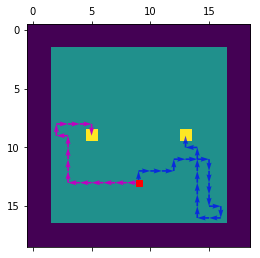

In [44]:
size = 15
PC_traces = []
torch.manual_seed(7)
hidden = torch.randn(1, 512)
for i in range(1):
#     start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (13, 9)
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_1_28'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
   
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'b', alpha = 0.7)

1.0 1.0


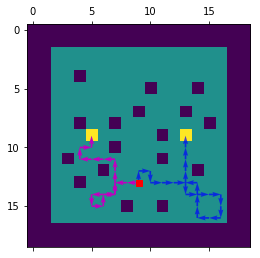

In [43]:
size = 15
PC_traces = []
torch.manual_seed(7)
hidden = torch.randn(1, 512)
for i in range(1):
#     start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (13, 9)
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_1_28'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
   
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'b', alpha = 0.7)

-1 1.0


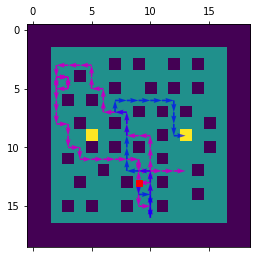

In [42]:
size = 15
PC_traces = []
torch.manual_seed(7)
hidden = torch.randn(1, 512)
for i in range(1):
#     start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (13, 9)
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_1_28'
    game = ValueMaxGame(grid_size = (size, size), holes = 1000, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
   
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'b', alpha = 0.7)

In [15]:
torch.norm(game.net.state_dict()['h2h']), torch.norm(game.net.state_dict()['a2h'])

(tensor(38.3464), tensor(11.6679))

1.0 1.0


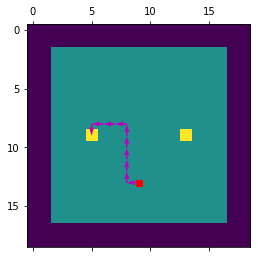

In [33]:
PC_traces = []
torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
#     start = (15, 15)
    weight = 'weights_fix2/rnn_1515tanh512_checkpoint39_0_29'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
   
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        x_f, y_f = x1[stop_w:], y1[stop_w:]
        plt.quiver(x_f[:-1], y_f[:-1], x_f[1:]-x_f[:-1], y_f[1:]-y_f[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

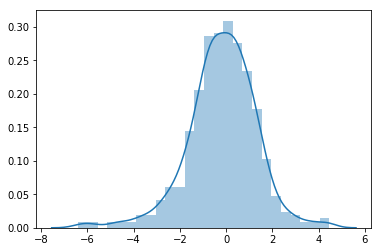

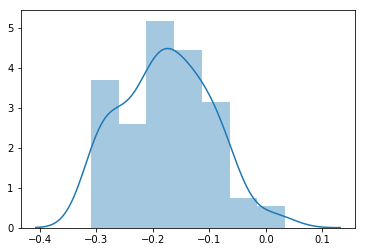

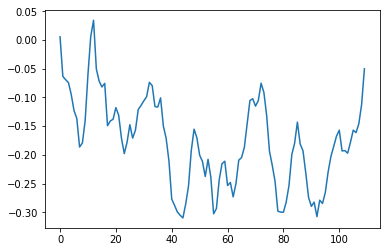

In [37]:
Input_h = np.array(Input_h).squeeze()
sns.distplot(np.mean(Input_h, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_h, axis = 1))
plt.figure()
plt.plot(np.mean(Input_h, axis = 1))

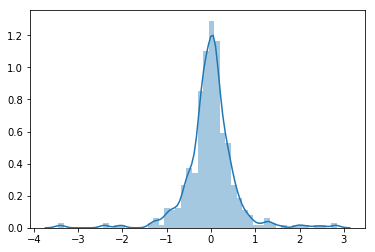

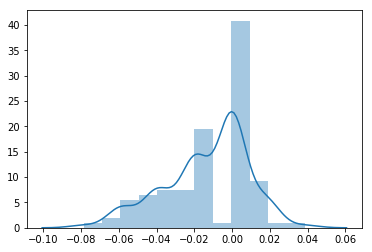

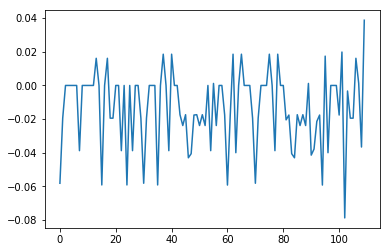

In [38]:
Input_i = np.array(Input_i).squeeze()
sns.distplot(np.mean(Input_i, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_i, axis = 1))
plt.figure()
plt.plot(np.mean(Input_i, axis = 1))

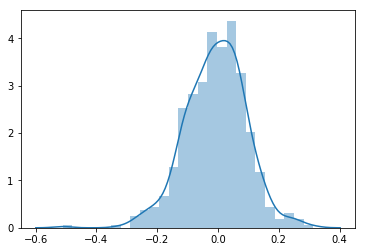

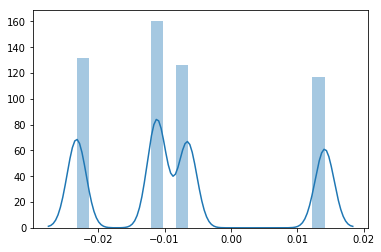

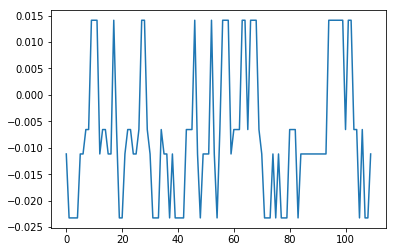

In [39]:
Input_a = np.array(Input_a).squeeze()
sns.distplot(np.mean(Input_a, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_a, axis = 1))
np.mean(Input_a, axis = 1)
plt.figure()
plt.plot(np.mean(Input_a, axis = 1))

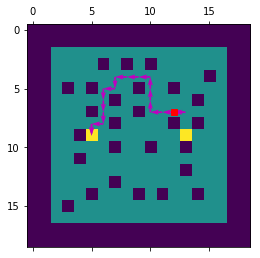

In [29]:
# action strengthened 
size = 15
PC_traces = []
torch.manual_seed(2)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
#     start = (15, 15)
    weight = 'weights_fix3/weights0/rnn_1515tanh512_checkpoint0_3_24'
    game = ValueMaxGame(grid_size = (size, size), holes = 200, random_seed = 14 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 10, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    game.net.k_action = 5
#     print (game.net.state_dict())
    start_w, stop_w = 16, 16
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1, Input_h, Input_i, Input_a  = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, Input_split = True)
    
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, Input_split = False)
  
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        x_f, y_f = x1[stop_w:], y1[stop_w:]
        plt.quiver(x_f[:-1], y_f[:-1], x_f[1:]-x_f[:-1], y_f[1:]-y_f[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

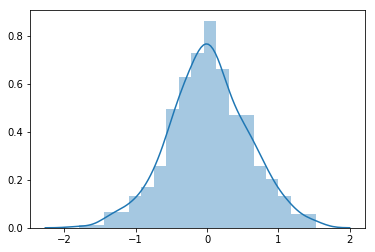

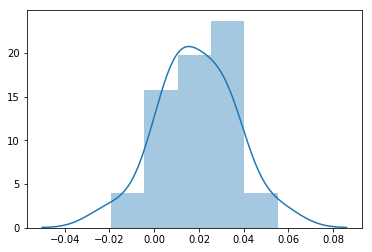

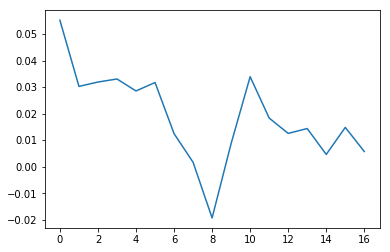

In [105]:
Input_h = np.array(Input_h).squeeze()
sns.distplot(np.mean(Input_h, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_h, axis = 1))
plt.figure()
plt.plot(np.mean(Input_h, axis = 1))

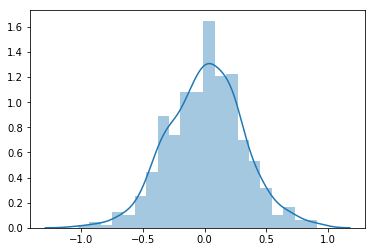

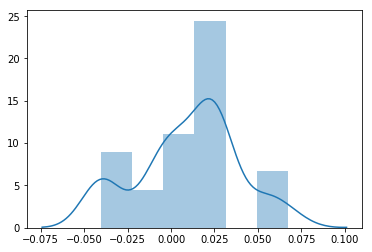

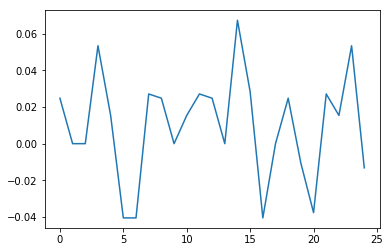

In [97]:
Input_i = np.array(Input_i).squeeze()
sns.distplot(np.mean(Input_i, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_i, axis = 1))
plt.figure()
plt.plot(np.mean(Input_i, axis = 1))

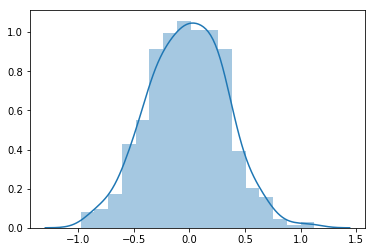

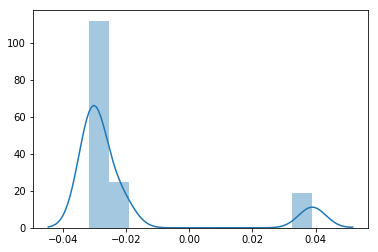

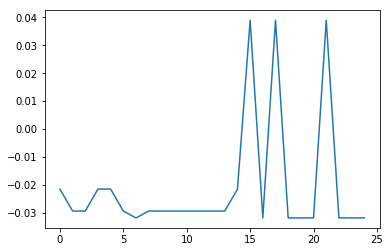

In [98]:
Input_a = np.array(Input_a).squeeze()
sns.distplot(np.mean(Input_a, axis = 0))
plt.figure()
sns.distplot(np.mean(Input_a, axis = 1))
np.mean(Input_a, axis = 1)
plt.figure()
plt.plot(np.mean(Input_a, axis = 1))

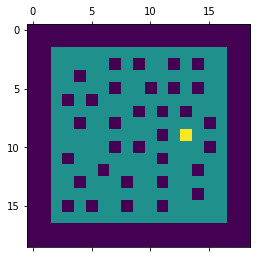

In [8]:
game = ValueMaxGame(grid_size = (15, 15), holes = 400, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_coupling = 1.0, discount = 0.9, alpha = 1, time_limit=8,
                   lam = 0)

start_w, stop_w = 16, 16
grid = game.grid.grid.copy()
for pos in game.Set_reward:
    grid[pos[0], pos[1]] = 0
    break
plt.matshow(grid)

In [72]:
np.save('performance_holes39.npy', Performance39)
np.save('performance_holes0.npy', Performance0)
np.save('performance_holes1.npy', Performance1)
np.save('performance_holes11.npy', Performance11)
# np.save('performance_holes17.npy', Performance17)

## Decoding check   

In [3]:
Precision_blank = []

Pretest =  PretrainTest(holes = 50, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0), action_coupling = 0.0)
Prec = Pretest.decode(epsilon = 1, k_action = 0)
Precision_blank.append(Prec[0])
print (Prec[0])
np.save('Precision_blank_random.npy', Precision_blank)

clear session data 4 3208220672
0 5.660074941441529
clear session data 4 3300909056
1 5.243613829878947
decode train finish 5.451844385660237
5.451844385660237


In [4]:
Precision_blank = []

Pretest =  PretrainTest(holes = 50, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0), action_coupling = 0.1)
Prec = Pretest.decode(epsilon = 1, k_action = 100)
Precision_blank.append(Prec[0])
print (Prec[0])
np.save('Precision_blank_random.npy', Precision_blank)

clear session data 4 3220123648
0 6.594493924686706
clear session data 4 3312275456
1 6.047618756071335
decode train finish 6.3210563403790205
6.3210563403790205


In [113]:
Precision_blank_r = []

Pretest =  PretrainTest(holes = 50, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0))
Prec = Pretest.decode(epsilon = 1)
Precision_blank_r.append(Prec[0])
print (Prec[0])
np.save('Precision_blank_random.npy', Precision_blank_r)

clear session data 4 3179397120
0 6.003758939736461
clear session data 4 3271958528
1 5.727061413431014
decode train finish 5.865410176583737
5.865410176583737


In [71]:
Precision_blank_r = []
distribution = []
for trial in [0, 39]:
    Pretest =  PretrainTest(holes = 50, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(39), inputs_type=(1, 0))
    Prec = Pretest.decode(epsilon = 1)
    Precision_blank_r.append(Prec[0])
    print (trial, Prec[0])
    plt.figure()
    distribution.append(Prec[1].ravel())
    np.save('Precision_blank_random.npy', Precision_blank_r)

clear session data 4 2874937344
0 5.434047181582432
clear session data 4 2967408640
1 5.53825365549771
decode train finish 5.486150418540071
0 5.486150418540071
clear session data 4 2875797504
0 5.288213610465687
clear session data 4 2968268800
1 5.601555386672931
decode train finish 5.444884498569309
39 5.444884498569309


In [72]:
np.save('distribution', distribution)

In [74]:
distribution_49 = np.load('distribution_49.npy')

In [76]:
distribution = np.concatenate((distribution, distribution_49), axis = 0)

(0, 5)

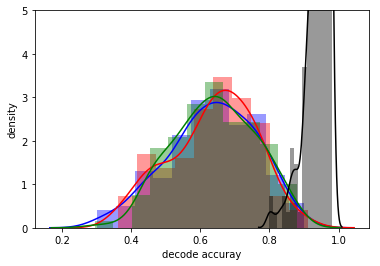

In [85]:
distribution_pos = np.load('distribution_pos_random.npy')
colors = ['b', 'r', 'g']
labels = ['echo state', 'pretrain1', 'pretrain2']
for i, d in enumerate(distribution):
    sns.distplot(1- d/15, color = colors[i], kde = True)
    plt.legend()
sns.distplot(1 - distribution_pos/15, color = 'k', label = 'position net')
# plt.legend()
plt.xlabel('decode accuray')
plt.ylabel('density')
plt.ylim(0, 5)

**right corner is used as strategical point**
**First time to see limit cycle used that way, think a bit outside navigation, limit cycle can characterize different features, for example orientation here , it is only one example. Need to check limit cycle used in general neuroscience**

**The solution we see is a cross scale solution,  we have the limit cycles for larger size arena, and during one limit cycle , the trace is for scaning micro space corresponding to strategy in smaller arena**

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**